### Напишем свою процедуру преобразования rgb2hsv

#### 1. Импорт и исследование изображения

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import imageio

In [2]:
URL = 'https://d2xzmw6cctk25h.cloudfront.net/assets/new_home_page/digital_1-f11c6b39d1efc99137abd87781fd0c5873346d0e73af779fc386853ed969dd7c.jpg'

In [3]:
img = imageio.imread(URL)

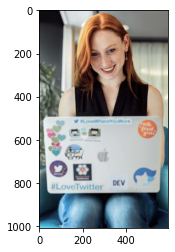

In [4]:
plt.imshow(img)

In [5]:
img.shape

(1008, 596, 3)

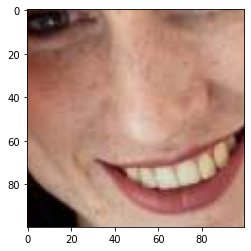

In [6]:
img_c = np.copy(img[200:300, 250:350])
plt.imshow(img_c)

In [7]:
x = 290
y = 270
n = 20
im_part = np.copy(img[y : y+n, x : x+n])

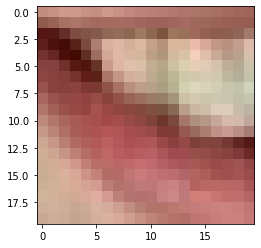

In [8]:
plt.imshow(im_part)

#### 2. Собственно процедура

##### На что стоит обратить внимание (с чем столкнулся и помучился):      
     1) Формулы данны не совсем корректно в части нормирования. Не нужно умножать насыщенность и яркость на сто, а цвет нужно нормировать к единице, а не отражать в градусях или радианах.
     2) Формулы не описывают как обрабатывать неоднозначность (равенство макисимумов)
     3) Внутри процедуры нужно использовать полный float, отказавшись от int8 и float32. Первое приводит к неправильному расчету цвета, так как 360 > 255. Второе нужно для добавления малой величины в целях борьбы с неоднозначностью.

In [9]:
def my_rgb2hsv(img):
    # -------------------------------------
    # 1 Divide r, g, b by 255
    norm_img = img/255
    d = 10**(-10)  # Добавляем небольшое смещение чтобы избежать неоднозначности при определениию максимумов и делении на 0
    for i in range(3):
        norm_img[:, :, 1] = norm_img[:, :, 1] + d*(i+1)
    
    # -------------------------------------
    # 2 Compute cmax, cmin, difference
    cmax = np.max(norm_img, axis=2)
    cmin = np.min(norm_img, axis=2)
    diff = cmax - cmin
    
    # -------------------------------------
    # 3 Hue calculations:
    #     if cmax and cmin equal 0, then h = 0
    #     if cmax equal r then compute h = (60 * ((g – b) / diff) + 360) % 360
    #     if cmax equal g then compute h = (60 * ((b – r) / diff) + 120) % 360
    #     if cmax equal b then compute h = (60 * ((r – g) / diff) + 240) % 360
    
    # Постараемся избежать поэлементного приенения конструкций if и перевести все на язык numpy
    cmax_eq_rgb = (cmax == norm_img[:, :, 0]).astype('int')  # Получаем 1 на месте максимума для r
    cmax_eq_rgb[np.where((cmax_eq_rgb == 0)&(cmax == norm_img[:, :, 1]))] = 2  # Получаем 2 на месте максимума для g
    cmax_eq_rgb[np.where((cmax_eq_rgb == 0)&(cmax == norm_img[:, :, 2]))] = 3  # Получаем 3 на месте максимума для b
    cmax_eq_rgb = cmax_eq_rgb - 1
    
    cmax_eq_rgb_mask = np.array([cmax, cmax, cmax])
    cmax_eq_rgb_mask = np.moveaxis(cmax_eq_rgb_mask, [0, 1, 2], [2, 0, 1])
    cmax_eq_rgb_mask = (cmax_eq_rgb_mask == norm_img).astype('int8')
    cmax_eq_rgb_mask_shift1 = cmax_eq_rgb_mask * 0
    cmax_eq_rgb_mask_shift2 = cmax_eq_rgb_mask * 0
    for i in range(3):
        cmax_eq_rgb_mask_shift1[:, :, (i + 1)%3] = cmax_eq_rgb_mask[:, :, i]
        cmax_eq_rgb_mask_shift2[:, :, (i + 2)%3] = cmax_eq_rgb_mask[:, :, i]
    
    cmax_eq_rgb_shift_0 = (cmax_eq_rgb + 2) % 3 + 1  # Преобразуем 0->3, 1->1, 2->2
    alpha = cmax_eq_rgb_shift_0 * 120
    h = (60 * (((norm_img * cmax_eq_rgb_mask_shift1).sum(axis=2) -
                (norm_img * cmax_eq_rgb_mask_shift2).sum(axis=2))/diff)
         + alpha) % 360
    #------------------------------
    # Saturation computation : 
    #    if cmax = 0, then s = 0
    #    if cmax does not equal 0 then s = (diff/cmax)*100
    # Умножать на 100 не нужно
    s = (cmax != 0).astype('int8') * (diff/cmax)
    
    # -----------------------------
    # Value computation : 
    # v = cmax*100
    # Умножать на 100 не нужно
    v = cmax
    out_img = norm_img * 0
    
#     print('norm_img', norm_img.shape)
#     print('h', h.shape)
#     print('s', s.shape)
#     print('v', v.shape)
    out_img[:, :, 0] = h/360
    out_img[:, :, 1] = s
    out_img[:, :, 2] = v
#     print('out_img', out_img.shape)
    return out_img.astype('float32')

Проверяем на малом участке (нужно раскомментить принты)

In [10]:
img_hsv_part = my_rgb2hsv(im_part)

In [11]:
img_hsv_part

array([[[3.5353534e-02, 3.4375000e-01, 7.5294119e-01],
        [3.5353534e-02, 3.3502537e-01, 7.7254903e-01],
        [3.5353534e-02, 3.2038835e-01, 8.0784315e-01],
        ...,
        [3.1400967e-02, 4.2073169e-01, 6.4313728e-01],
        [2.6960785e-02, 4.2500001e-01, 6.2745100e-01],
        [2.6570048e-02, 4.3396226e-01, 6.2352943e-01]],

       [[3.4825873e-02, 4.6853146e-01, 5.6078434e-01],
        [3.4825873e-02, 4.4078946e-01, 5.9607846e-01],
        [3.1400967e-02, 4.1071430e-01, 6.5882355e-01],
        ...,
        [3.1400967e-02, 4.5098040e-01, 6.0000002e-01],
        [2.6570048e-02, 4.5394737e-01, 5.9607846e-01],
        [2.6570048e-02, 4.5695364e-01, 5.9215689e-01]],

       [[2.6881725e-03, 7.4698794e-01, 3.2549021e-01],
        [1.0582011e-02, 7.5903612e-01, 3.2549021e-01],
        [1.3888889e-02, 6.0000002e-01, 3.9215687e-01],
        ...,
        [3.7634410e-02, 4.3971631e-01, 5.5294120e-01],
        [3.8011696e-02, 3.9583334e-01, 5.6470591e-01],
        [4.6296299e-02

Сравниваем с тем, что дает встроенный метод

In [12]:
from skimage.color import hsv2rgb, rgb2hsv

In [13]:
rgb2hsv(im_part)

array([[[0.03535354, 0.34375   , 0.75294118],
        [0.03535354, 0.33502538, 0.77254902],
        [0.03535354, 0.32038835, 0.80784314],
        ...,
        [0.03140097, 0.42073171, 0.64313725],
        [0.02696078, 0.425     , 0.62745098],
        [0.02657005, 0.43396226, 0.62352941]],

       [[0.03482587, 0.46853147, 0.56078431],
        [0.03482587, 0.44078947, 0.59607843],
        [0.03140097, 0.41071429, 0.65882353],
        ...,
        [0.03140097, 0.45098039, 0.6       ],
        [0.02657005, 0.45394737, 0.59607843],
        [0.02657005, 0.45695364, 0.59215686]],

       [[0.00268817, 0.74698795, 0.3254902 ],
        [0.01058201, 0.75903614, 0.3254902 ],
        [0.01388889, 0.6       , 0.39215686],
        ...,
        [0.03763441, 0.43971631, 0.55294118],
        [0.0380117 , 0.39583333, 0.56470588],
        [0.0462963 , 0.33540373, 0.63137255]],

       ...,

       [[0.08333333, 0.25961538, 0.81568627],
        [0.07309942, 0.27142857, 0.82352941],
        [0.06321839, 0

Пробуем преобразовать всю картинку (туда своим сетодом, обратно встроенным)

In [14]:
my_img_hsv = my_rgb2hsv(img)

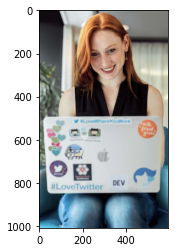

In [15]:
plt.imshow(hsv2rgb(my_img_hsv))

#### 3. Определим процедуру для печати картинки с заданными сдвигами по hsv

Значение hue двигаем по кругу, saturation и value обрезаем по (0, 1)

In [16]:
def change_im(im_rgb, h_delta, s_delta, v_delta):
    im_hsv = my_rgb2hsv(im_rgb)
    im_hsv[:, :, 0] = (im_hsv[:, :, 0] + h_delta)*10%10/10
    im_hsv[:, :, 1] = np.clip(im_hsv[:, :, 1] + s_delta, a_min=0, a_max=1)
    im_hsv[:, :, 2] = np.clip(im_hsv[:, :, 2] + v_delta, a_min=0, a_max=1)
    new_im = hsv2rgb(im_hsv)
    plt.imshow(new_im)
    return new_im

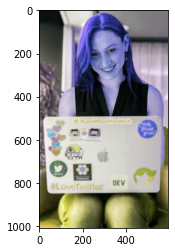

In [23]:
_ = change_im(img, h_delta=0.6, s_delta=0, v_delta=0)